# Setup

## Imports

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
%matplotlib inline

## Elo Model

In [ ]:
class Elo(nn.Module):
    def __init__(self, k_form="constant",
                       init_k=1, init_k_b=1,    # For the constant model, multi model, and bias
                       init_k_c=1, init_k_d=1,  # For the linear model
                       init_R_A=1000, init_R_B=1000, fix_init_R_A=False, fix_init_R_B=False):
        super(Elo, self).__init__()
        self.k_form = k_form
        if k_form == "constant":
            self.k = torch.nn.Parameter(torch.Tensor([init_k]))
        elif k_form == "linear":
            self.k_c = torch.nn.Parameter(torch.Tensor([init_k_c]))
            self.k_d = torch.nn.Parameter(torch.Tensor([init_k_d]))
        elif k_form == "multi":
            self.k_1 = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_2 = torch.nn.Parameter(torch.Tensor([init_k]))
        elif k_form == "shared-bias":
            self.k = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_b = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "different-bias":
            self.k = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_b_A = torch.nn.Parameter(torch.Tensor([init_k_b]))
            self.k_b_B = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "multi+shared-bias":
            self.k_1 = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_2 = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_b = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "multi+different-bias":
            self.k_1 = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_2 = torch.nn.Parameter(torch.Tensor([init_k]))
            self.k_b_A = torch.nn.Parameter(torch.Tensor([init_k_b]))
            self.k_b_B = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "log+shared-bias":
            self.log_k = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.k_b = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "log+different-bias":
            self.log_k = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.k_b_A = torch.nn.Parameter(torch.Tensor([init_k_b]))
            self.k_b_B = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "multi-log+shared-bias":
            self.log_k_1 = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.log_k_2 = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.k_b = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "multi-log+different-bias":
            self.log_k_1 = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.log_k_2 = torch.nn.Parameter(torch.Tensor([np.log(init_k)]))
            self.k_b_A = torch.nn.Parameter(torch.Tensor([init_k_b]))
            self.k_b_B = torch.nn.Parameter(torch.Tensor([init_k_b]))
        elif k_form == "every":
            self.k_t = torch.nn.Parameter(torch.Tensor([init_k] * 100))
        else:
            raise Exception("invalid k_form: "+ k_form)
        
        if fix_init_R_A:
            self.init_R_A = torch.Tensor([init_R_A])
        else:
            self.init_R_A = torch.nn.Parameter(torch.Tensor([init_R_A]))
        if fix_init_R_B:
            self.init_R_B = torch.Tensor([init_R_B])
        else:
            self.init_R_B = torch.nn.Parameter(torch.Tensor([init_R_B]))
        
    def get_param_names(self):
        return [name for name, value in self.named_parameters() if value.requires_grad]

    def expected_score(self, R_A, R_B):
        E_A = 1 / (1 + 10 ** ((R_B - R_A) / 400))
        E_B = 1 / (1 + 10 ** ((R_A - R_B) / 400))

        return E_A, E_B

    def get_k_t(self, t):
        if self.k_form == "constant":
            return self.k
        elif self.k_form == "linear":
            return self.k_c * t + self.k_d
        elif self.k_form == "multi":
            return [self.k_1, self.k_2]
        elif self.k_form == "shared-bias":
            return [self.k, self.k_b]
        elif self.k_form == "different-bias":
            return [self.k, self.k_b_A, self.k_b_B]
        elif self.k_form == "multi+shared-bias":
            return [self.k_1, self.k_2, self.k_b]
        elif self.k_form == "multi+different-bias":
            return [self.k_1, self.k_2, self.k_b_A, self.k_b_B]
        elif self.k_form == "log+shared-bias":
            return [torch.exp(self.log_k), self.k_b]
        elif self.k_form == "log+different-bias":
            return [torch.exp(self.log_k), self.k_b_A, self.k_b_B]
        elif self.k_form == "multi-log+shared-bias":
            return [torch.exp(self.log_k_1), torch.exp(self.log_k_2), self.k_b]
        elif self.k_form == "multi-log+different-bias":
            return [torch.exp(self.log_k_1), torch.exp(self.log_k_2), self.k_b_A, self.k_b_B]
        elif self.k_form == "every":
            return self.k_t[t]

    def forward(self, R_A, R_B, S_A, S_B, t):

        S_A = torch.Tensor([S_A])
        S_B = torch.Tensor([S_B])

        E_A, E_B = self.expected_score(R_A, R_B)

        if self.k_form in ["constant", "linear", "every"]:
            k = self.get_k_t(t)
            new_R_A = R_A + k * (S_A - E_A)
            new_R_B = R_B + k * (S_B - E_B)
        elif self.k_form in ["multi"]:
            k_1, k_2 = self.get_k_t(t)
            new_R_A = R_A + k_1 * S_A - k_2 * E_A
            new_R_B = R_B + k_1 * S_B - k_2 * E_B
        elif self.k_form in ["shared-bias"]:
            k, k_b = self.get_k_t(t)
            new_R_A = R_A + k * (S_A - E_A) + k_b
            new_R_B = R_B + k * (S_B - E_B) - k_b
        elif self.k_form in ["different-bias"]:
            k, k_b_A, k_b_B = self.get_k_t(t)
            new_R_A = R_A + k * (S_A - E_A) + k_b_A
            new_R_B = R_B + k * (S_B - E_B) + k_b_B
        elif self.k_form in ["multi+shared-bias"]:
            k_1, k_2, k_b = self.get_k_t(t)
            new_R_A = R_A + k_1 * S_A + k_2 * E_A + k_b
            new_R_B = R_B + k_1 * S_B + k_2 * E_B - k_b
        elif self.k_form in ["multi+different-bias"]:
            k_1, k_2, k_b_A, k_b_B = self.get_k_t(t)
            new_R_A = R_A + k_1 * S_A + k_2 * E_A + k_b_A
            new_R_B = R_B + k_1 * S_B + k_2 * E_B + k_b_B
        elif self.k_form in ["log+shared-bias"]:
            k, k_b = self.get_k_t(t)
            new_R_A = R_A + k * (S_A - E_A) + k_b
            new_R_B = R_B + k * (S_B - E_B) - k_b
        elif self.k_form in ["log+different-bias"]:
            k, k_b_A, k_b_B = self.get_k_t(t)
            new_R_A = R_A + k * (S_A - E_A) + k_b_A
            new_R_B = R_B + k * (S_B - E_B) + k_b_B
        elif self.k_form in ["multi-log+shared-bias"]:
            k_1, k_2, k_b = self.get_k_t(t)
            new_R_A = R_A + k_1 * S_A - k_2 * E_A + k_b
            new_R_B = R_B + k_1 * S_B - k_2 * E_B - k_b
        elif self.k_form in ["multi-log+different-bias"]:
            k_1, k_2, k_b_A, k_b_B = self.get_k_t(t)
            new_R_A = R_A + k_1 * S_A - k_2 * E_A + k_b_A
            new_R_B = R_B + k_1 * S_B - k_2 * E_B + k_b_B
        return new_R_A, new_R_B


## Synthetic Data

In [ ]:
def make_synthetic_data(init_win_rate,
                        final_win_rate,
                        rounds,
                        noise=0,
                        seed=0,
                        rating_type="linear"):
    assert init_win_rate == 0 and final_win_rate == 0.5 or rating_type == "linear", "non-linear ratings not implemented for non-learning agent"
    np.random.seed(seed)
    probs = np.linspace(init_win_rate + 1/3 * (1 - init_win_rate),
                        final_win_rate + 1/3 * (1 - final_win_rate),
                        rounds)
    results = []
    for p in probs:
        result = np.random.binomial(n=1, p=p)
        if result == 0:
            result += 0.5 * np.random.binomial(n=1, p=0.5)
        results.append(result)
    results = np.array(results)
    if rating_type == "linear":
        rating = probs
    elif rating_type == "convex":
        rating = 1/3 + (1/(3 * rounds ** 2)) * np.arange(rounds) ** 2
    elif rating_type == "concave":
        rating = 2/3 - (1/(3 * rounds ** 2)) * (np.arange(rounds) - rounds) ** 2
    elif rating_type == "sigmoid":
        rating = 1/3 + 1/3 * ( 1 / (1 + np.exp(- 0.1 * np.arange(rounds) + rounds / 20)) )
    rating += np.random.normal(0, noise, rounds)
    return np.stack((probs, results, 1-results, rating)).T

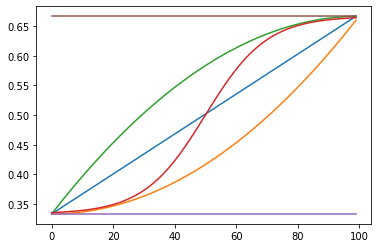

In [ ]:
for rating_type in ["linear", "convex", "concave", "sigmoid"]:
    data = make_synthetic_data(0, 0.5, 100, seed=0, noise=0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings)
for rating_type in ["linear"]:
    data = make_synthetic_data(0, 0, 100, seed=0, noise=0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings)
for rating_type in ["linear"]:
    data = make_synthetic_data(0.5, 0.5, 100, seed=0, noise=0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings)

## Fit Elo Model

In [ ]:
def fit_elo(data, k_form, n, num_iters, lr=0.5, **kwargs):
    elo = Elo(k_form=k_form, **kwargs)
    optimizer = torch.optim.Adam(elo.parameters(), lr=lr)
    losses = []
    params = {key: [] for key in elo.get_param_names()}

    for i in range(num_iters):
        loss = 0
        R_As = [elo.init_R_A]
        R_Bs = [elo.init_R_B]
        E_A, E_B = elo.expected_score(R_As[-1], R_Bs[-1])
        E_As = [E_A]
        E_Bs = [E_B]
        probs, scores_A, scores_B, ys = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
        for i, (y, S_A, S_B) in enumerate(zip(ys, scores_A, scores_B)):
            if i % n == 0:
                new_S_A = sum(scores_A[i:i+n])
                new_S_B = sum(scores_B[i:i+n])
                new_R_A, new_R_B = elo(R_As[-1], R_Bs[-1], new_S_A, new_S_B, i)
                R_As.append(new_R_A)
                R_Bs.append(new_R_B)
                new_E_A, new_E_B = elo.expected_score(new_R_A, new_R_B)
                E_As.append(new_E_A)
                E_Bs.append(new_E_B)
                loss_i = -y * torch.log(new_E_A) - (1-y) * torch.log(new_E_B)
                loss += loss_i
        losses.append(loss.item())
        param_values = [p for p in elo.parameters()]
        for i, name in enumerate(elo.get_param_names()):
            params[name].append(param_values[i].item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses = np.array(losses)
    params = {key: np.array(values) for key, values in params.items()}
    ks = np.array([elo.get_k_t(t) for t in range(0, len(data), n)])
    return {"elo": elo,
            "losses": losses,
            "params": params,
            "E_As": E_As,
            "E_Bs": E_Bs,
            "R_As": R_As,
            "R_Bs": R_Bs,
            "ks": ks
    }

## Plotting

In [ ]:
def plot(**kwargs):
    nargs = len(kwargs)
    fig, axs = plt.subplots(nrows=1, ncols=nargs, figsize=(nargs * 3, 2))

    for i, (key, value) in enumerate(kwargs.items()):
        if type(value) is dict:
            if len(value.items()) > 2:
                all_inner_values = np.array([inner_value for inner_value in value.values()])
                mean = np.mean(all_inner_values, axis=0)
                std = np.std(all_inner_values, axis=0)
                axs[i].errorbar(np.arange(len(mean)), mean, std, linestyle='None', marker='o')
            else:
                for inner_key, inner_value in value.items():
                    axs[i].plot(inner_value, label=inner_key)
                axs[i].legend()
        else:
            axs[i].plot(value)
        axs[i].set_title(key)
        if "loss" in key or key in ["k","k_b", "k_1", "k_2", "k_c", "k_d"] or "init_R" in key:
            axs[i].set_xlabel("epoch")
        else:
            axs[i].set_xlabel("round")

In [ ]:
def plot_predictions_and_convergence(data, out, n=5, rating_col=3):
    kwargs ={"human_est_win_prob": data[:, rating_col][::n],
              "model_est_win_prob": out["E_As"],
              "model_ratings": {"ratings_A": out["R_As"],
                                "ratings_B": out["R_Bs"]}
                }

    kwargs.update({'losses': out['losses']})
    kwargs.update(out['params'])
    plot(**kwargs)

In [ ]:
def plot_evaluation(out, n=5, rating_col=3):
    kwargs ={"human_est_win_prob": out["datas"][:, rating_col][::n],
             "model_est_win_prob": {i: out["E_Ass"][i] for i in range(len(out["E_Ass"]))}
            }
    print("Validation loss:", out["losses"].mean().round(2), "+-", out["losses"].std().round(2))
    plot(**kwargs)

## Evaluate Elo Model

In [ ]:
def evaluate_elo(elo, data_kwargs, seeds=20, n=5):
    elo.eval()
    losses = []
    E_Ass = []
    datas = []
    for seed in range(seeds):
        data_kwargs["seed"] = 100 + seed
        data = make_synthetic_data(**data_kwargs)
        datas.append(data)
        loss = 0
        R_As = [elo.init_R_A]
        R_Bs = [elo.init_R_B]
        E_A, E_B = elo.expected_score(R_As[-1], R_Bs[-1])
        E_As = [E_A.item()]
        E_Bs = [E_B.item()]
        probs, scores_A, scores_B, ys = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
        for i, (y, S_A, S_B) in enumerate(zip(ys, scores_A, scores_B)):
            if i % n == 0:
                new_S_A = sum(scores_A[i:i+n])
                new_S_B = sum(scores_B[i:i+n])
                new_R_A, new_R_B = elo(R_As[-1], R_Bs[-1], new_S_A, new_S_B, i)
                R_As.append(new_R_A)
                R_Bs.append(new_R_B)
                new_E_A, new_E_B = elo.expected_score(new_R_A, new_R_B)
                E_As.append(new_E_A.item())
                E_Bs.append(new_E_B.item())
                loss_i = -y * torch.log(new_E_A) - (1-y) * torch.log(new_E_B)
                loss += loss_i
        losses.append(loss.item())
        E_Ass.append(E_As)
    return {"losses": np.array(losses),
            "E_Ass": np.array(E_Ass),
            "datas": data
            }

# Elo Experiments

In [ ]:
def get_syn_params(rating_type):
    return {"init_win_rate": 0, "final_win_rate": 0.5, "rounds": 100, "noise":0, "rating_type":rating_type}

def syn(rating_type, seed):
    params = get_syn_params(rating_type)
    return make_synthetic_data(**params, seed=seed)

## Different Initializations -> Different Solutions


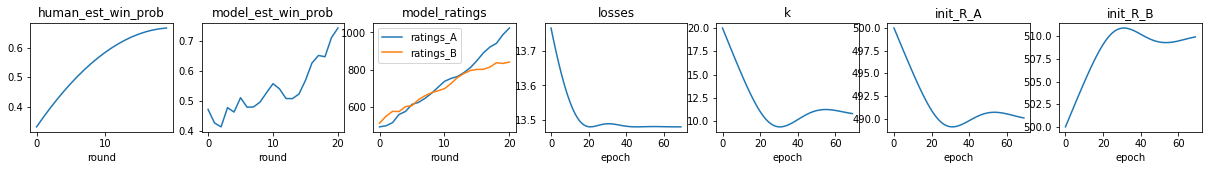

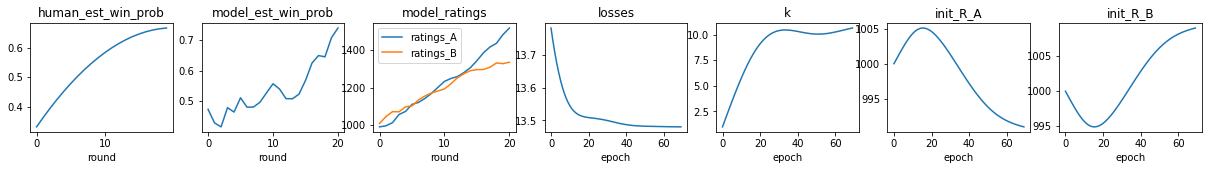

In [ ]:
out_const_k_init1 = fit_elo(syn("concave", 1), "constant", n=5, num_iters=70, init_k=20, init_R_A=500, init_R_B=500)
out_const_k_init2 = fit_elo(syn("concave", 1), "constant", n=5, num_iters=70, init_k=1, init_R_A=1000, init_R_B=1000)

for out in [out_const_k_init1, out_const_k_init2]:
    plot_predictions_and_convergence(concave_data_1, out)

## Fix Initial Opponent Rank -> Different Initializations Arrive at Similar Solution

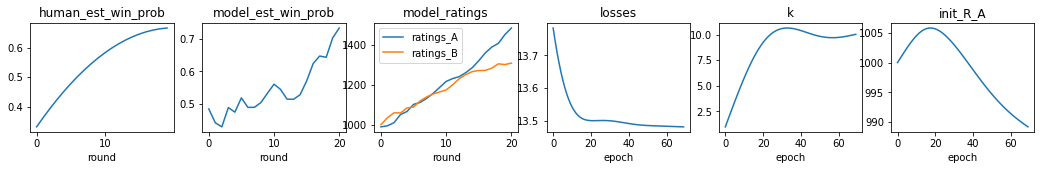

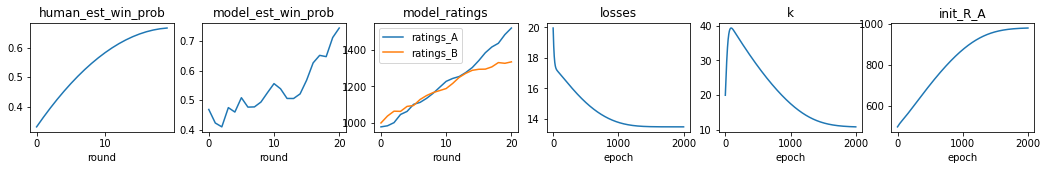

In [ ]:
out_const_k_init1_fixedRB = fit_elo(syn("concave", 1), "constant", n=5, num_iters=70, init_k=1, init_R_A=1000, fix_init_R_B=True)
out_const_k_init2_fixedRB = fit_elo(syn("concave", 1), "constant", n=5, num_iters=2000, init_k=20, init_R_A=500, fix_init_R_B=True)

for out in [out_const_k_init1_fixedRB, out_const_k_init2_fixedRB]:
    plot_predictions_and_convergence(concave_data_1, out)

Validation loss: 13.67 +- 0.22


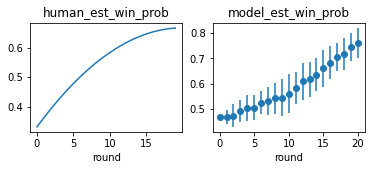

In [ ]:
out = evaluate_elo(out_const_k_init1["elo"], get_syn_params("concave"))
plot_evaluation(out)

## Linear K -> Seems to fit better

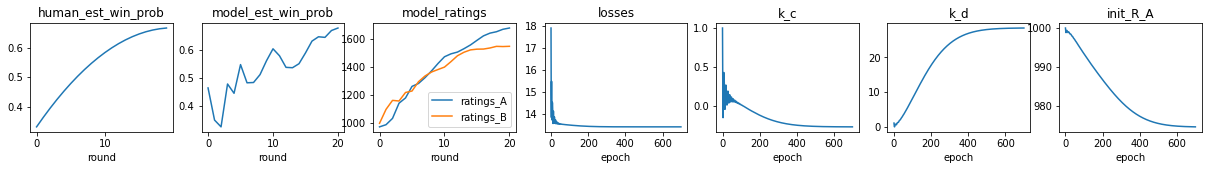

In [ ]:
out_linear_k_fixedRB = fit_elo(syn("concave", 1), "linear", n=5, num_iters=700, lr=0.5, init_k=1, fix_init_R_B=True)
for out in [out_linear_k_fixedRB]:
    plot_predictions_and_convergence(concave_data_1, out)

Validation loss: 14.2 +- 0.88


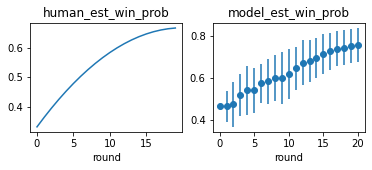

In [ ]:
out = evaluate_elo(out_linear_k_fixedRB["elo"], get_syn_params("concave"))
plot_evaluation(out)

## Try multi, shared-bias, different-bias, multi+shared-bias, multi+different-bias

Validation loss: 14.13 +- 0.36


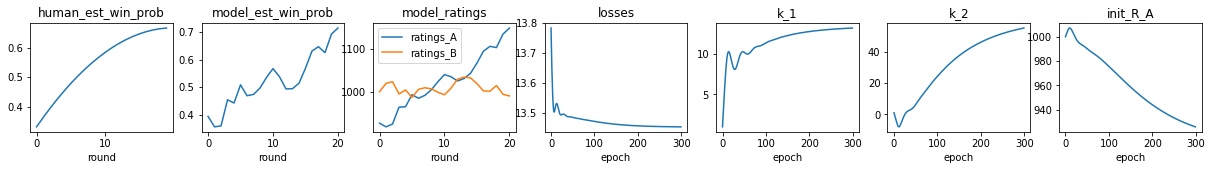

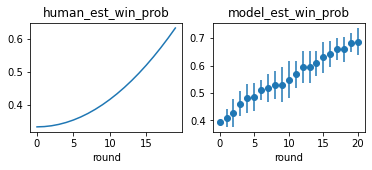

In [ ]:
out_multi = fit_elo(concave_data_1, "multi", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_multi)

out = evaluate_elo(out_multi["elo"], get_syn_params("concave"))
plot_evaluation(out)

Validation loss: 13.41 +- 0.07


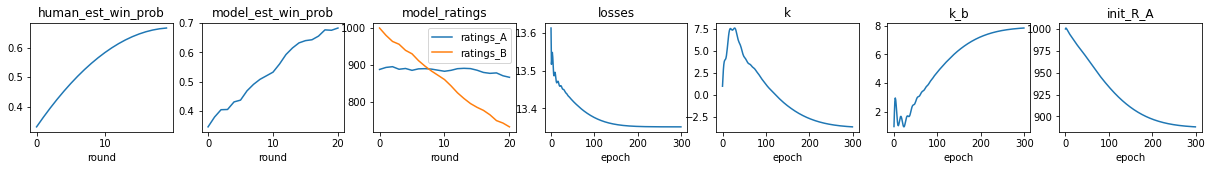

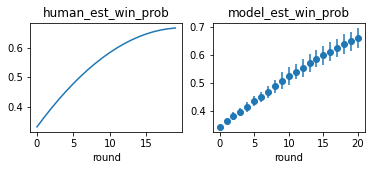

In [ ]:
out_shared_bias = fit_elo(concave_data_1, "shared-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_shared_bias)

out = evaluate_elo(out_shared_bias["elo"], get_syn_params("concave"))
plot_evaluation(out)

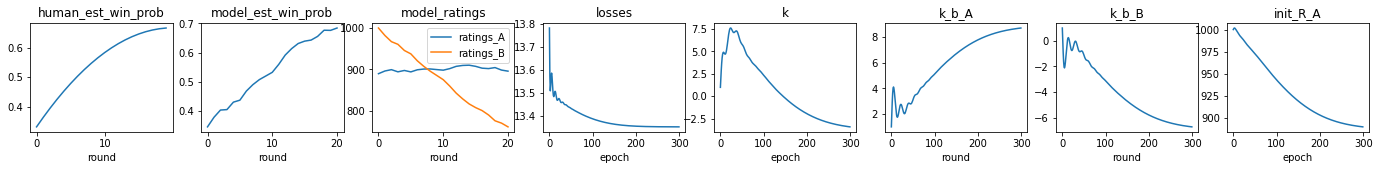

In [ ]:
out_different_bias = fit_elo(concave_data_1, "different-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_different_bias)

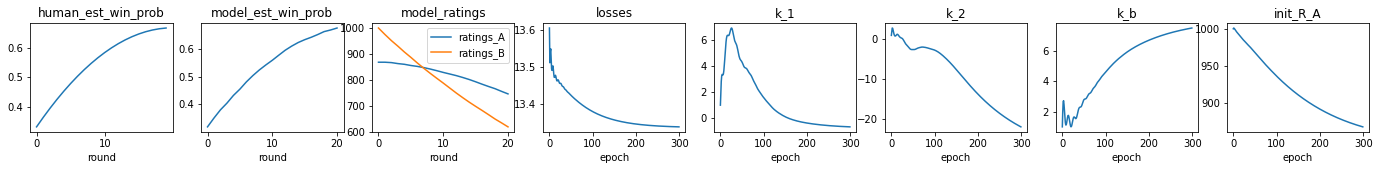

In [ ]:
out_multi_shared_bias = fit_elo(concave_data_1, "multi+shared-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_multi_shared_bias)

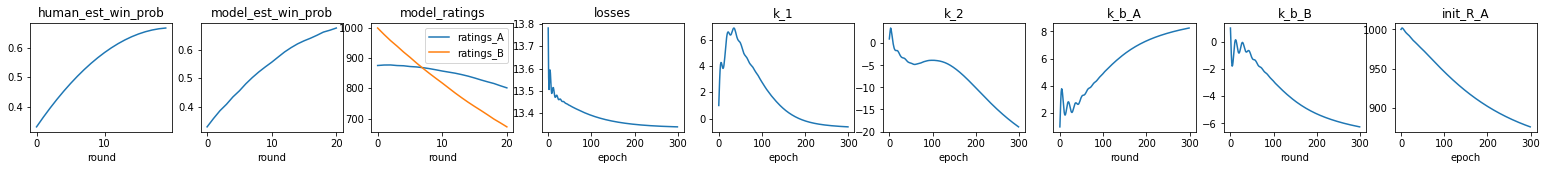

In [ ]:
out_multi_different_bias = fit_elo(concave_data_1, "multi+different-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_multi_different_bias)

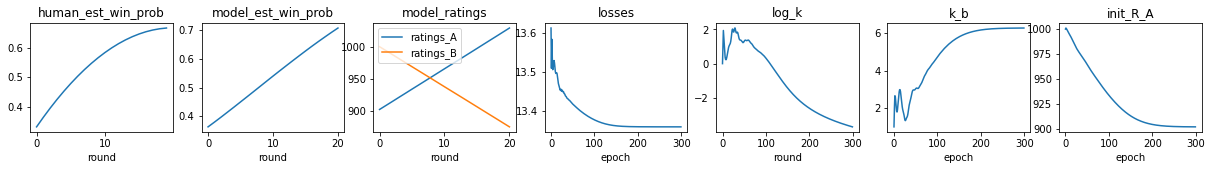

In [ ]:
out_log_shared_bias = fit_elo(concave_data_1, "log+shared-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_log_shared_bias)

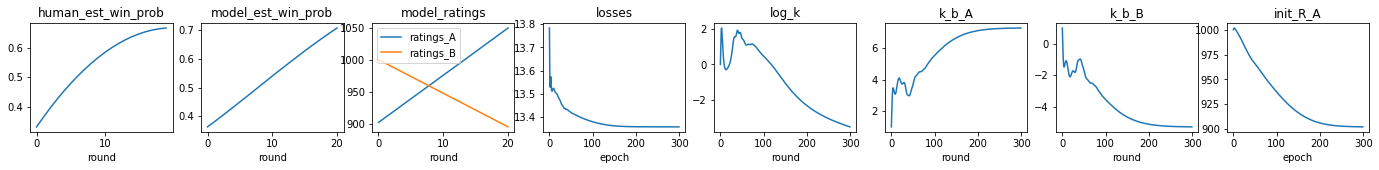

In [ ]:
out_log_different_bias = fit_elo(concave_data_1, "log+different-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_log_different_bias)

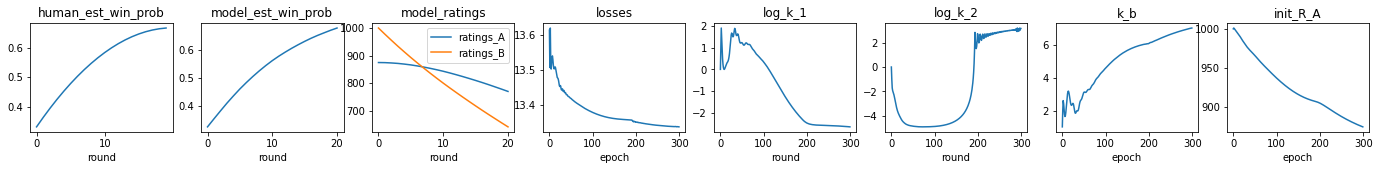

In [ ]:
out_multi_log_shared_bias = fit_elo(concave_data_1, "multi-log+shared-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_multi_log_shared_bias)

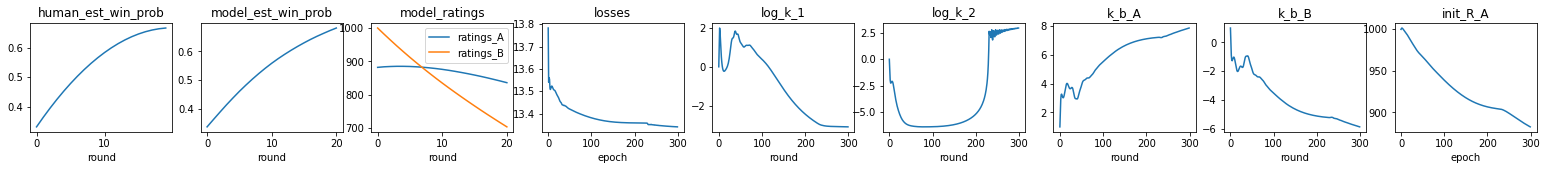

In [ ]:
out_multi_log_different_bias = fit_elo(concave_data_1, "multi-log+different-bias", n=5, num_iters=300, lr=1, init_k=1, fix_init_R_B=True)
plot_predictions_and_convergence(concave_data_1, out_multi_log_different_bias)

In [ ]:
sig_data_1 = make_synthetic_data(0, 0.5, 100, seed=1, noise=0, rating_type="sigmoid")


In [ ]:
sig_data_1

array([[0.33333333, 0.5       , 0.5       , 0.33556428],
       [0.33670034, 0.        , 1.        , 0.33579718],
       [0.34006734, 0.        , 1.        , 0.33605419],
       [0.34343434, 0.        , 1.        , 0.33633777],
       [0.34680135, 0.5       , 0.5       , 0.3366506 ],
       [0.35016835, 0.5       , 0.5       , 0.33699565],
       [0.35353535, 0.5       , 0.5       , 0.33737614],
       [0.35690236, 0.5       , 0.5       , 0.33779564],
       [0.36026936, 0.5       , 0.5       , 0.33825801],
       [0.36363636, 0.        , 1.        , 0.3387675 ],
       [0.36700337, 1.        , 0.        , 0.33932874],
       [0.37037037, 1.        , 0.        , 0.33994677],
       [0.37373737, 0.5       , 0.5       , 0.34062709],
       [0.37710438, 1.        , 0.        , 0.34137567],
       [0.38047138, 1.        , 0.        , 0.342199  ],
       [0.38383838, 0.        , 1.        , 0.34310408],
       [0.38720539, 0.5       , 0.5       , 0.34409849],
       [0.39057239, 0.        ,

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=199ccc49-bf50-455b-987a-f3756c1aa6a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>